# TELECOM CUSTOMER CHURN PREDICTION

## 0. Import

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import plotly.express as px
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score,roc_auc_score,classification_report
from sklearn.metrics import roc_curve

# I. Data cleaning
## 1.1 Đọc dữ liệu từ đường dẫn Excel hoặc csv
* Nếu đọc file thành công thì sẽ thông báo thành công. Ngược lại nếu không thành công thì sẽ yêu cầu nhập lại cho đến khi thành công.

In [108]:
np.set_printoptions(precision=4, suppress=True)
def input_data():
    while True:
        file_path = input("Vui lòng nhập đường dẫn đến file (.csv hoặc .xlsx): ").strip('"').replace("\\", "/")
        try:
            if file_path.endswith('.csv'):
                data = pd.read_csv(file_path)
                print("Dữ liệu từ file CSV đã được đọc thành công.")
                break  # Thoát khỏi vòng lặp nếu đọc file thành công
            elif file_path.endswith('.xlsx'):
                data = pd.read_excel(file_path)
                print("Dữ liệu từ file Excel đã được đọc thành công.")
                print(data.head())
                break  # Thoát khỏi vòng lặp nếu đọc file thành công
            else:
                print("Định dạng file không hợp lệ. Vui lòng nhập file có định dạng .csv hoặc .xlsx.")
        except FileNotFoundError:
            print("Không tìm thấy file. Vui lòng kiểm tra lại đường dẫn.")
    return data

In [109]:
data = pd.read_csv('Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Ở đây ta thấy trường thông tin "TotalCharges" đang được định dạng là dạng chữ, ta sẽ định dạng nó về dạng số

In [111]:
data['TotalCharges'] = pd.to_numeric(data.TotalCharges, errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [112]:
(data.drop(['SeniorCitizen'], axis = 1)).describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


## 1.2 Loại bỏ cột không cần thiết
* Tìm trong file nếu có cột nào không có ý nghĩa trong mô hình dự đoán thì có thể loại bỏ 
* Như trong file "Telco-Customer-Churn" ta thấy rằng cột "customerID" không có ý nghĩa trong mô hình dự đoán nên có thể loại bỏ.

In [113]:
data = data.drop(['customerID'], axis = 1)
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Bộ dữ liệu bao gồm các thông tin về:
* Khách hàng hủy đăng ký vào tháng trước - cột Churn
* Các dịch vụ mà khách hàng đăng kí (điện thoại, mạng, ...)
* Thông tin về tài khoản của khách hàng(các thức thanh toán, hợp đồng,...)
* Thông tin cá nhân của khách hàng (giới tính, tuổi tác,...)

## 1.3 Xử lý dữ liệu bị thiếu, null.
- Ta sẽ xóa đi những dòng có giá trị bị thiếu (null)

In [114]:
data.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [115]:
data[np.isnan(data['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [116]:
tt_missing = data.isnull().sum().sum()
print(f"Phần trăm dữ liệu thiếu là: {tt_missing/len(data)*100:.2f}%")

Phần trăm dữ liệu thiếu là: 0.16%


Ta thấy dữ liệu thiếu chỉ chiếm 0.16% dữ liệu tổng thể, nên ta có thể xóa đi những dòng có giá trị thiếu đó mà không quá ảnh hưởng đến mô hình

In [117]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

Bộ dữ liệu sau khi được xóa các giá trị "NaN" đã thu gọn từ 7043 dòng xuống còn 7032 dòng

## 1.4 Kiểm tra Outliter

Text(0, 0.5, 'TotalCharges')

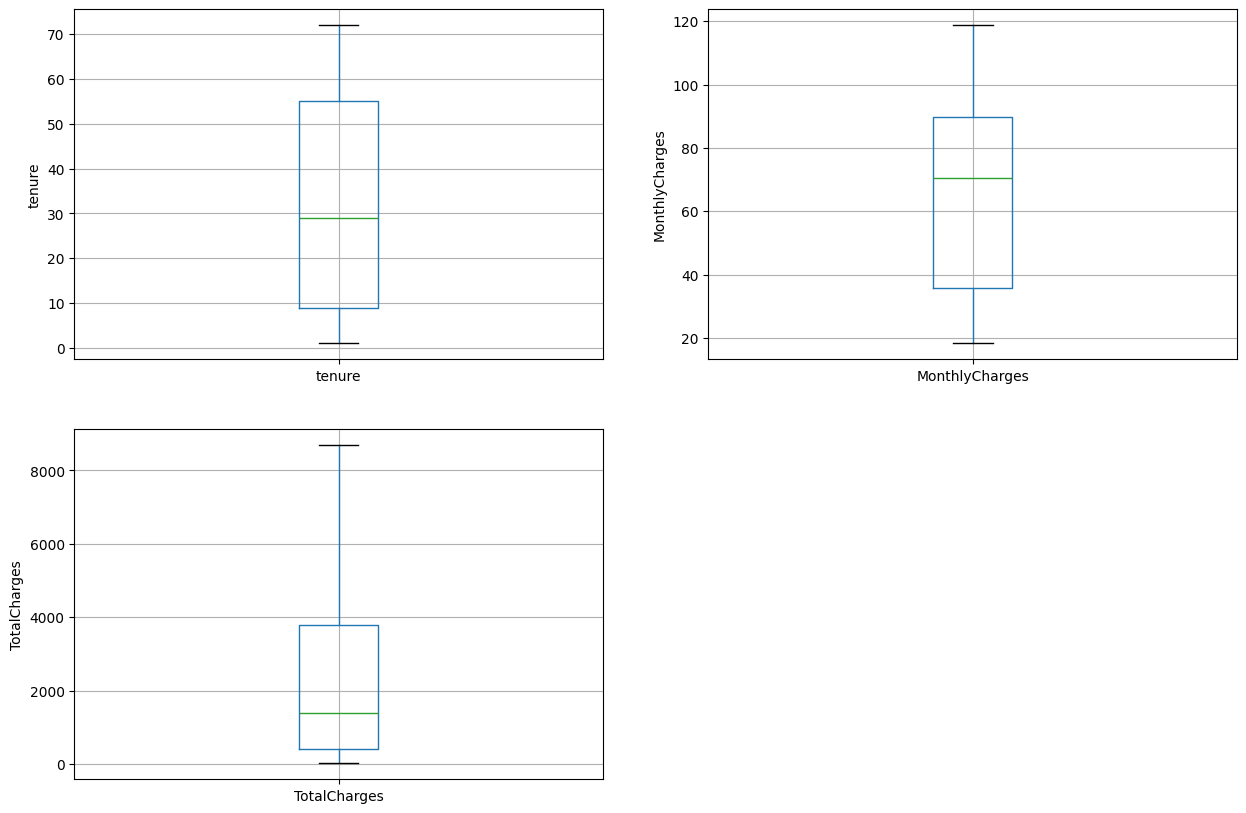

In [118]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
fig = data.boxplot(column='tenure')
fig.set_title('')
fig.set_ylabel('tenure')


plt.subplot(2, 2, 2)
fig = data.boxplot(column='MonthlyCharges')
fig.set_title('')
fig.set_ylabel('MonthlyCharges')


plt.subplot(2, 2, 3)
fig = data.boxplot(column='TotalCharges')
fig.set_title('')
fig.set_ylabel('TotalCharges')

Bộ dữ liệu không có Outliter

## II. Data Visualization

#### 2.0 Ma trận tương quan

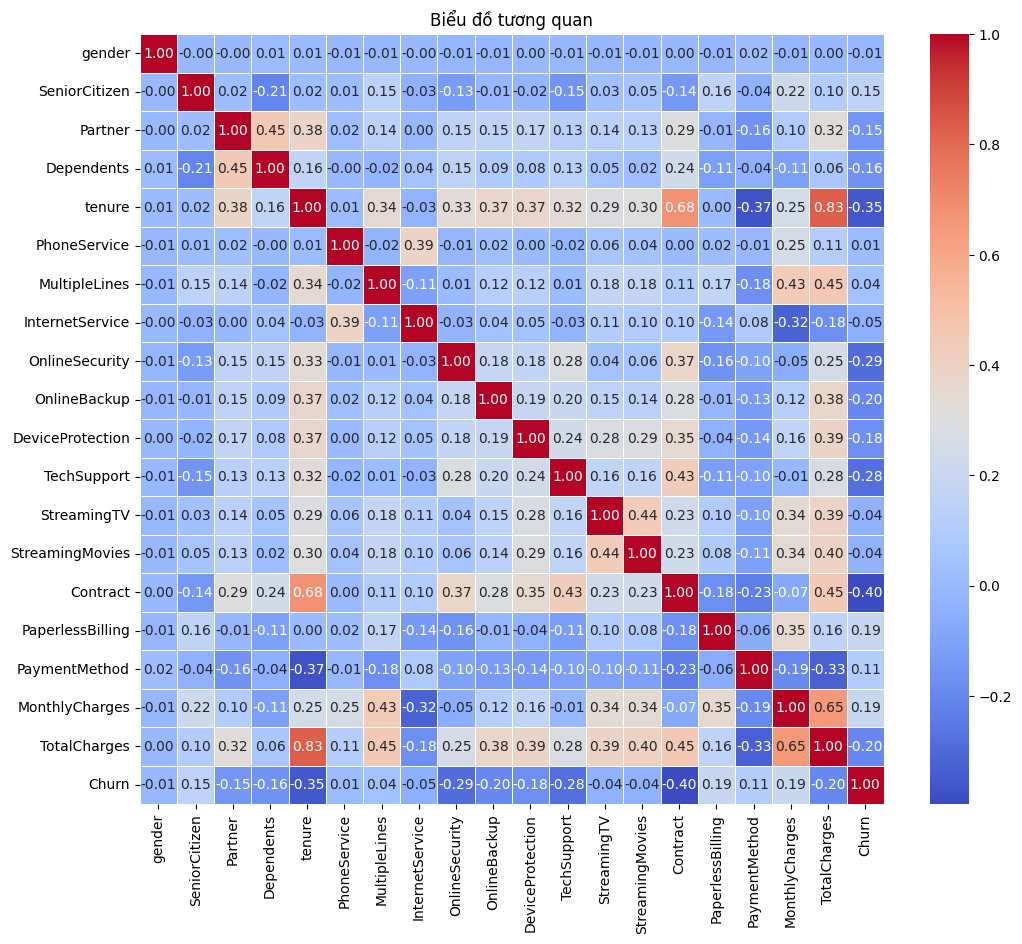

In [119]:
data_encoded = data.copy()

# Mã hóa các cột kiểu object (chữ) sang số
label_encoders = {}
for col in data_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col].astype(str))
    label_encoders[col] = le  # Lưu nếu muốn inverse_transform sau này

# Tính ma trận tương quan
corr = data_encoded.corr()

# Vẽ heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Biểu đồ tương quan')
plt.show()

#### 2.1 Mối quan hệ giữa giới tính (Gender) và tỉ lệ rời bỏ

In [120]:
g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=g_labels, values=data['gender'].value_counts(), name="Gender"),
              1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=data['Churn'].value_counts(), name="Churn"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Gender and Churn Distributions",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Gender', x=0.19, y=0.5, font_size=20, showarrow=False),
                 dict(text='Churn', x=0.8, y=0.5, font_size=20, showarrow=False)])
fig.show()

* Có 26.6% khách hàng rời bỏ ngành dịch vụ
* Có 49.5% người tiêu dùng là nữ và đối với nam là 50.5%

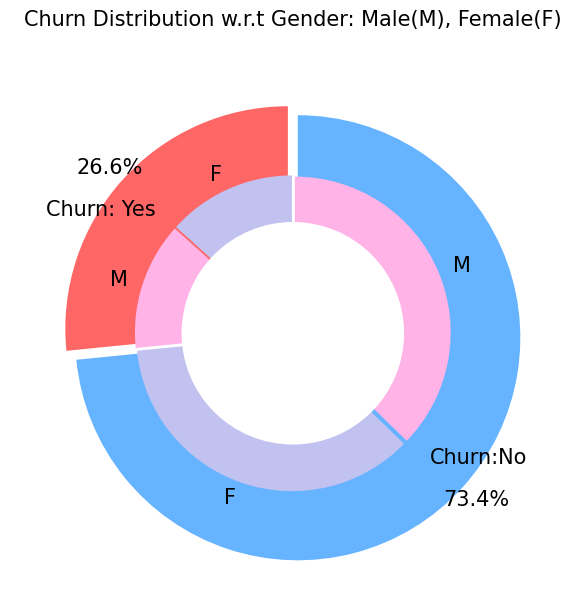

In [121]:
plt.figure(figsize=(6, 6))
labels =["Churn: Yes","Churn:No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939,930 , 2544,2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

* Nhìn trên biểu đồ trên ta có thể thấy rằng việc khách hàng rời bỏ ngành dịch vụ không liên quan đến giới tính của khách hàng. Cả hai giới tính đều có xu hướng cũng như nhu cầu sử dụng tương đương nhau

#### 2.2 Mối quan hệ giữa phương thức thanh toán (Payment Method) và tỉ lệ rời bỏ

In [122]:
labels = data['PaymentMethod'].unique()
values = data['PaymentMethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

In [123]:

fig = px.histogram(data, x="Churn", color="PaymentMethod", title="<b>Customer Payment Method distribution w.r.t. Churn</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

* Có thể nhận thấy rằng những người trả bằng séc điện tử (Electronic Check) có xu hướng rời bỏ ngành dịch vụ cao hơn

#### 2.3 Mối quan hệ giữa dịch vụ mạng (Internet Service) và tỉ lệ rời bỏ

In [124]:
fig = px.histogram(data, x="Churn", color="InternetService", title="<b>Customer Internet Service distribution w.r.t. Churn</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()


* Có thể thấy rằng khách hàng lựa chọn dịch vụ cáp quang (Fiber optic) có tỉ lệ rời bỏ cao hơn so với các loại dịch vụ mạng khác
* Khách hàng sử dụng dịch vụ DSL dường như rất hài lòng với dịch vụ của nhà mạng.

#### 2.4 Mối quan hệ giữa hỗ trợ kĩ thuật (Techsupport) và tỉ lệ rời bỏ

In [125]:
fig = px.histogram(data, x="Churn", color="TechSupport",barmode="group",  title="<b>Chrun distribution w.r.t. TechSupport</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()


* Một điều rõ ràng rằng những khách hàng không đăng kí bảo mật trực tuyến (Online security) hoặc không có hỗ trợ kỹ thuật (Techsupport) sẽ có tỉ lệ rời bỏ cao hơn.

#### 2.5 Mối quan hệ giữa bảo mật trực tuyến (Internet Service) và tỉ lệ rời bỏ

In [126]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(data, x="Churn", color="OnlineSecurity", barmode="group", title="<b>Churn w.r.t Online Security</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Biểu đồ tương quan**

# III. Build Model

## 3.1 Xử lý biến
Ở bài toán này, ta sẽ chia dữ liệu ra thành 3 phần
* Chuẩn hóa các cột có trường dữ liệu là số
* One-hot encoding cho các biến "PaymentMethod", "Contract", "InternetService" 
* Label encoding cho các biến phân độc lập còn lại

In [127]:
def custom_encoding(data):
    df = data.copy()

    # Cột cần One-Hot Encoding
    one_hot_cols = ['PaymentMethod', 'Contract', 'InternetService']
    df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True, dtype=int)

    # Label Encoding các cột object còn lại
    for col in df.select_dtypes(include='object').columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    return df



In [128]:
def standardize_numerical_only(df, target_col='Churn'):
    df_scaled = df.copy()

    # Lấy danh sách các cột số (int, float) 
    numerical_cols = df_scaled.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Loại trừ các biến nhị phân (0/1) ra khỏi danh sách chuẩn hóa
    binary_cols = [col for col in numerical_cols if df_scaled[col].dropna().isin([0, 1]).all()]
    cols_to_scale = [col for col in numerical_cols if col not in binary_cols and col != target_col]

    # Chuẩn hóa
    scaler = StandardScaler()
    df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

    return data 
data = custom_encoding(data)
data = standardize_numerical_only(data)
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_One year,Contract_Two year,InternetService_Fiber optic,InternetService_No
0,0,0,1,0,1,0,1,0,2,0,...,29.85,29.85,0,0,1,0,0,0,0,0
1,1,0,0,0,34,1,0,2,0,2,...,56.95,1889.50,0,0,0,1,1,0,0,0
2,1,0,0,0,2,1,0,2,2,0,...,53.85,108.15,1,0,0,1,0,0,0,0
3,1,0,0,0,45,0,1,2,0,2,...,42.30,1840.75,0,0,0,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,0,1,0,0,0,1,0


## 3.2 Chọn biến độc lập và biến phụ thuộc

In [129]:
X = data.drop(columns = ['Churn'])
y = data['Churn'].values

In [130]:
# Chia bộ dữ liệu ra thành tập train và tập test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


## 3.3 Kiểm tra mức độ cân bằng dữ liệu

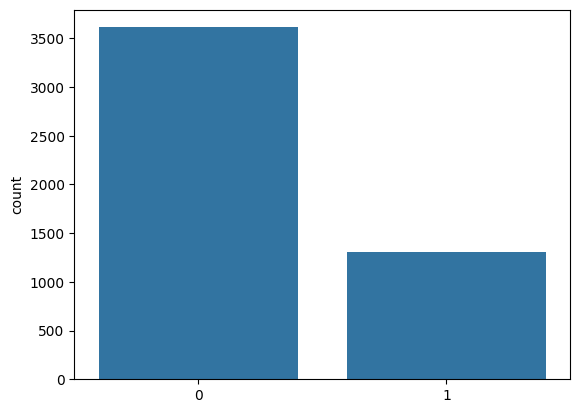

Label 0: 3614 samples (73.43%)
Label 1: 1308 samples (26.57%)


In [131]:

# Kiểm tra tỉ lệ các lớp
sns.countplot(x=y_train)
plt.show()

unique, counts = np.unique(y_train, return_counts=True)
percentages = counts / len(y_train)

for u, c, p in zip(unique, counts, percentages):
    print(f"Label {u}: {c} samples ({p:.2%})")


Bộ train có mức độ không cân bằng khá cao. Với 73.43% mẫu là được đánh nhãn 0 (No) và 26.57% mẫu được đánh nhãn 1 (Yes)

Tiến hành cân bằng mẫu bằng cách tăng số lượng mẫu cho lớp thiểu số (Oversampling), sử dụng hàm có sẵn "SMOTE".

In [132]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

unique, counts = np.unique(y_train_resampled, return_counts=True)
percentages = counts / len(y_train_resampled)

for u, c, p in zip(unique, counts, percentages):
    print(f"Label {u}: {c} samples ({p:.2%})")

Label 0: 3614 samples (50.00%)
Label 1: 3614 samples (50.00%)


Sau khi điều chỉnh thì tỉ lệ của hai nhãn đã bằng nhau

## 3.4 Hiệu chỉnh siêu tham số (Hyperparameter Tuning)

In [133]:
# Định nghĩa mô hình Logistic Regression cơ bản
log_reg = LogisticRegression(max_iter=1000)

# Lưới các tham số cần tìm
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2'],
    'max_iter': [1000, 2000]
}

# Tìm tham số tốt nhất với GridSearchCV
grid_search = GridSearchCV(estimator=log_reg,
                           param_grid=param_grid,
                           scoring='f1',   # hoặc 'roc_auc'
                           cv=5,
                           n_jobs=-1)

# Huấn luyện mô hình trên tập train
grid_search.fit(X_train_resampled, y_train_resampled)

# In tham số tốt nhất tìm được
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}


## 3.5 Chạy mô hình và đánh giá kết quả

In [134]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Xác suất lớp 1 (churn)

# Tính các chỉ tiêu
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
roc_auc = roc_auc_score(y_test, y_proba)

# In kết quả
print("=== Evaluation Metrics ===")
print(f"Accuracy:   {accuracy:.2f}")
print(f"Precision:  {precision:.2f}")
print(f"Recall:     {recall:.2f}")
print(f"F1-score:   {f1:.2f}")
print(f"ROC AUC:    {roc_auc:.2f}")


=== Evaluation Metrics ===
Accuracy:   0.75
Precision:  0.53
Recall:     0.71
F1-score:   0.61
ROC AUC:    0.82


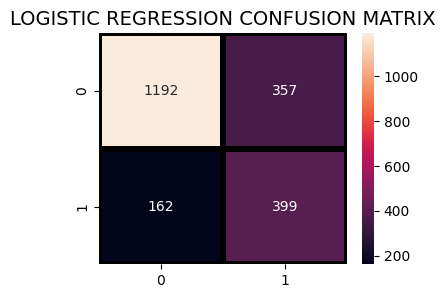

In [135]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("LOGISTIC REGRESSION CONFUSION MATRIX",fontsize=14)
plt.show()

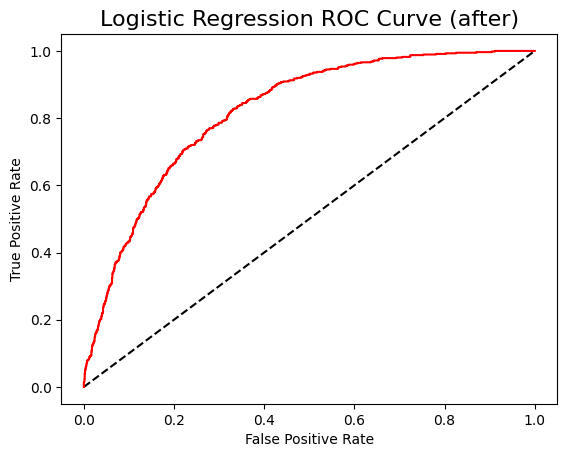

In [136]:
y_pred_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Logistic Regression',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve (after)',fontsize=16)
plt.show();

## Phụ luc ( so sánh kết quả với lúc chưa hiệu chỉnh tham số và chưa cân bằng lớp)

In [137]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
accuracy_lr = lr_model.score(X_test,y_test)
print("Logistic Regression accuracy is :",accuracy_lr)

Logistic Regression accuracy is : 0.8028436018957346


C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [138]:
lr_pred= lr_model.predict(X_test)
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]  # Xác suất lớp 1 (churn)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
roc_auc = roc_auc_score(y_test, y_proba)


In [139]:
# Tính các chỉ tiêu
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
roc_auc = roc_auc_score(y_test, y_proba)

# In kết quả
print("=== Evaluation Metrics ===")
print(f"Accuracy:   {accuracy:.2f}")
print(f"Precision:  {precision:.2f}")
print(f"Recall:     {recall:.2f}")
print(f"F1-score:   {f1:.2f}")
print(f"ROC AUC:    {roc_auc:.2f}")

=== Evaluation Metrics ===
Accuracy:   0.80
Precision:  0.65
Recall:     0.55
F1-score:   0.60
ROC AUC:    0.84


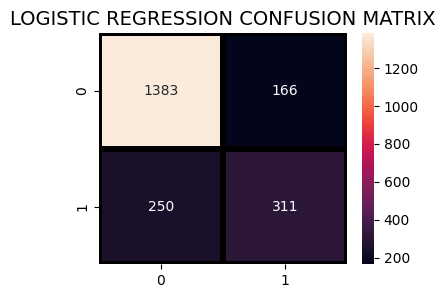

In [140]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("LOGISTIC REGRESSION CONFUSION MATRIX",fontsize=14)
plt.show()

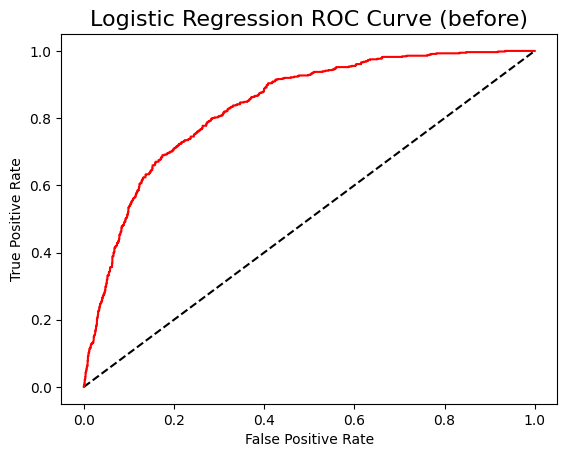

In [141]:
y_pred_prob = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Logistic Regression',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve (before)',fontsize=16)
plt.show();

Rõ ràng, sau khi điều chỉnh cân bằng lớp thì chỉ số "accuracy" và precision đã giảm đi (80% - 75% và 65% - 53%) nhưng "recall" tăng lên (55% -71%). Điều đó là cần thiết vì khi ta thêm mẫu dữ liệu để làm cho cân bằng lớp thì mô hình dễ dự đoán nhầm nhiều hơn, dẫn đến "precision" và "accuracy", nhưng đồng thời làm cho mô hình học kỹ hơn về lớp thiểu số, giúp tăng recall.

Điều này là thiết đối với thực tế đối với bài toán dự đoán khách hàng rời bỏ dịch vụ. Chúng ta ưu tiên việc có thể đoán đúng người rời bỏ dịch vụ, thậm trí đoán thừa còn hơn bỏ xót.